
# Automatic Number Plate detection


Downloading the Dataset from kaggle

In [1]:
! kaggle datasets download -d aslanahmedov/number-plate-detection

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors
 98% 404M/413M [00:03<00:00, 134MB/s]
100% 413M/413M [00:03<00:00, 118MB/s]


In [2]:
!unzip /content/number-plate-detection.zip

Archive:  /content/number-plate-detection.zip
  inflating: TEST/TEST.jpeg          
  inflating: TEST/TEST.mp4           
  inflating: data.yaml               
  inflating: images/N1.jpeg          
  inflating: images/N1.xml           
  inflating: images/N100.jpeg        
  inflating: images/N100.xml         
  inflating: images/N101.jpeg        
  inflating: images/N101.xml         
  inflating: images/N102.jpeg        
  inflating: images/N102.xml         
  inflating: images/N103.jpeg        
  inflating: images/N103.xml         
  inflating: images/N104.jpeg        
  inflating: images/N104.xml         
  inflating: images/N105.jpeg        
  inflating: images/N105.xml         
  inflating: images/N106.jpeg        
  inflating: images/N106.xml         
  inflating: images/N107.jpeg        
  inflating: images/N107.xml         
  inflating: images/N108.jpeg        
  inflating: images/N108.xml         
  inflating: images/N109.jpeg        
  inflating: images/N109.xml         
  in

In [3]:
from pathlib import Path
import shutil
from bs4 import BeautifulSoup
import os

Nomralizing annotations

In [4]:
def normalized_coordinates(filename, width, height, xmin, ymin, xmax, ymax):
    """Take in image coordinates (unnormalized) as input, return normalized values
    """

    xmin, xmax = xmin / width, xmax / width
    ymin, ymax = ymin / height, ymax/ height

    width = xmax-xmin
    height = ymax-ymin
    x_center = xmin + (width / 2)
    y_center = ymin + (height / 2)

    return x_center, y_center, width, height

def write_label(filename, x_center, y_center, width, height):
    """Save image's coordinates in text file named "filename"
    """
    with open(filename, mode='w') as outf:
        outf.write(f"{0} {x_center} {y_center} {width} {height}\n")

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d

def build_data(dir_folder, ann_file_list, img_dir):
    """Write xml labels to text file with specifications format, save at 'labels' folder.
        Move image to 'images' folder
    """
    images_folder = f"{dir_folder}/images"
    labels_folder = f"{dir_folder}/labels"

    os.makedirs(images_folder, exist_ok = True)
    os.makedirs(labels_folder, exist_ok = True)


    for ann_file in ann_file_list:
        with open(ann_file, 'r') as f:
            label = parse_xml_tags(f.read())

        img_file_name = label['filename']
        x_center, y_center, width, height = normalized_coordinates(**label)

        # save at 'labels' folder
        write_label(f"{labels_folder}/{img_file_name.split('.')[0]}.txt", x_center, y_center, width, height)

         # Move image to 'images' folder
        shutil.copy(f"{img_dir}/{img_file_name}", f"{images_folder}/{img_file_name}")


In [5]:
import glob
dir_folder = "/content/dataset"

ann_list = glob.glob('/content/images/*.xml')
print(len(ann_list))
build_data(dir_folder, ann_list, "/content/images/")

225


In [6]:
import yaml

data = {
    "path": dir_folder,
    "train": "images",
    "val": "",
    "names": {0: "car_lisence_plate"}
    }

with open('/content/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [7]:
assert len(os.listdir("/content/dataset/labels")) == len(os.listdir("/content/dataset/images"))

# Installing YOLOV5

In [8]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16836, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16836 (delta 1), reused 6 (delta 0), pack-reused 16825
Receiving objects: 100% (16836/16836), 15.58 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (11545/11545), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.

Train the YOLOV5 model using our data and annotations

In [9]:
!python train.py --img 640 --batch 16 --epochs 15 --data /content/dataset.yaml --weights yolov5s.pt --cache ram

2024-08-05 05:42:49.117423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 05:42:49.373905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 05:42:49.448574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=F

In [11]:
import torch

yolo = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-5 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Testing the model

WARNING ⚠️ NMS time limit 0.550s exceeded


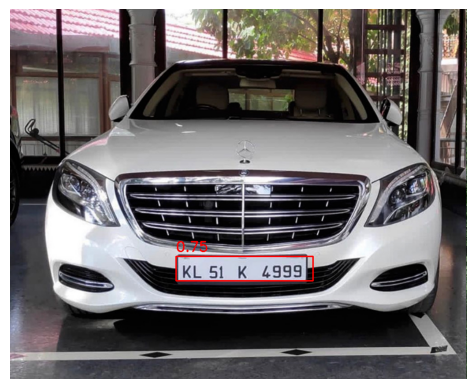

In [14]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

# Image path
img = '/content/TEST/TEST.jpeg'

img1 = cv.imread(img)

# Inference
results = yolo(img1)

# Get the coordinates and convert to a pandas DataFrame
coordinates = results.pandas().xyxy[0]

# Load the image
img_1 = cv.imread(img)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)

# Draw bounding boxes
for idx, row in coordinates.iterrows():
    xmin, ymin, xmax, ymax, confidence, class_id, name = row
    cv.rectangle(img_1, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
    cv.putText(img_1, f'{confidence:.2f}', (int(xmin), int(ymin) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Convert back to PIL Image and display
img_pil = Image.fromarray(img_1)
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

# Install EasyOCR for reading the number plates

In [15]:
!pip install easyocr -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 23.7 MB/s eta 0:00:00


In [20]:
def read_plate_number(results, frame, reader):
    n = len(results)
    x_shape, y_shape = frame.shape[1], frame.shape[0]

    for i in range(n):
        row = cordinates[i] # Iterate through each image
        if row[4] >= 0.5: ## Take img with 0.5 confidence
            xmin, ymin, xmax, ymax = row[:4]
            plate = frame[int(ymin):int(ymax), int(xmin):int(xmax)]

            ## Preprocess Plate
            gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
            blurred = cv.bilateralFilter(gray, 17, 15, 15)
#             ret, thresh = cv.threshold(blurred, 125, 255, cv.THRESH_BINARY)

            ## OCR
            text = reader.readtext(blurred)
            text = ' '.join([t[1] for t in text])

            plot_img = frame.copy()

            cv.rectangle(plot_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2) ## BBox
            cv.rectangle(plot_img, (int(xmin), int(ymin-20)), (int(xmax), int(ymin)), (0, 255,0), -1) ## for text label background
            final_img = cv.putText(plot_img, f"{text}", (int(xmin), int(ymin)), cv.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)

            return final_img

#             return cv.cvtColor(final_img, cv.COLOR_BGR2RGB)
#             cv.imwrite(f'/kaggle/working/labeled_img_{i}.jpg', cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

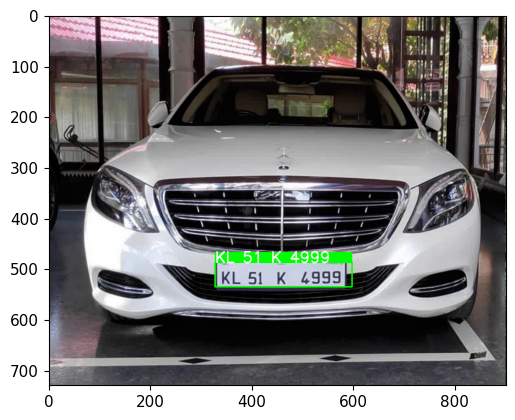

In [21]:
import matplotlib.pyplot as plt
import easyocr
%matplotlib inline

reader = easyocr.Reader(['en'])
# cordinates = cordinates.cpu().numpy()

frame = cv.imread(img) ### reading the image
frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)

cordinates = results.xyxy[0][:, :-1]
result_img = read_plate_number(cordinates, frame, reader)
plt.imshow(result_img)
plt.show();